# Advanced Lane Line Finding


In [1]:
# importlib reload vs jupyter autoreload
# from importlib import reload
# import utils; reload(utils)
%load_ext autoreload
%autoreload 1
%aimport utils
from utils import *
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib inline
import os

In [2]:
cal_dir = "camera_cal"
test_imgs_dir = "test_images"
out_imgs_dir = "output_images"
out_videos_dir = "output_videos"

### Get Test Images

In [3]:
test_img_paths = glob.glob(test_imgs_dir + "/*.jpg")
test_img_paths

['test_images\\straight_lines1.jpg',
 'test_images\\straight_lines2.jpg',
 'test_images\\test1.jpg',
 'test_images\\test2.jpg',
 'test_images\\test3.jpg',
 'test_images\\test4.jpg',
 'test_images\\test5.jpg',
 'test_images\\test6.jpg']

In [4]:
test_imgs = [utils.load_image(img) for img in test_img_paths]

In [5]:
def get_test_img_name(test_img_path):
    name_plus_ending = test_img_path.split('\\')[1]
    name = name_plus_ending.split('.')[0]
    return name
    
test_img_names = [get_test_img_name(path) for path in test_img_paths]
test_img_names

['straight_lines1',
 'straight_lines2',
 'test1',
 'test2',
 'test3',
 'test4',
 'test5',
 'test6']

# Camera Calibration and Undistortion
Let's first get the paths of all our calibration images. Note, when loading images with imread, they get stored in BGR color format. When using imshow, however, we need them in RGB color format. Therefore, we create in utils.py a convenience function load_img that loads the image and converts into RGB color format.

In [6]:
cal_img_paths = glob.glob(cal_dir + "/*.jpg")
print(len(cal_img_paths))

20


There are 20 images in the calibration image directory. Let's now take a look at the first chessboard image to see what it looks like. 

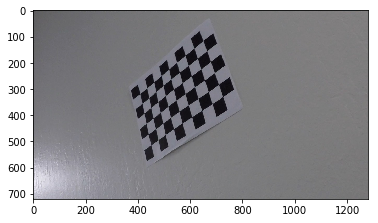

In [7]:
cal_img = utils.load_image(cal_img_paths[4])
plt.imshow(cal_img)

### Finding and Drawing Chessboard Corners

The Chessboard has 9x6 inner corners. We now use these parameters for the function `cv2.findChessboardCorners()`.

In [8]:
nx = 9
ny = 6

First of all, we feed the function a grayscaled image. 

In [9]:
gray = cv2.cvtColor(cal_img, cv2.COLOR_RGB2GRAY)

Now, we test the above functions with the first of the calibration images. 

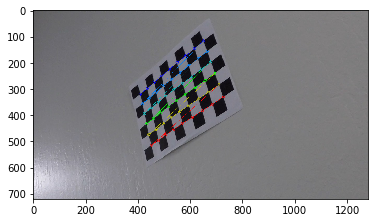

In [10]:
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
if ret == True:
    cv2.drawChessboardCorners(cal_img, (nx, ny), corners, ret)
    plt.imshow(cal_img)

The corner detection seems to be working, however not for all calibration images. Some images are too small, i.e. not all corners are visible. Next, we will use the found corners to undistort the camera. 

## Camera Calibration
With the above functions, we now create the camera matrix and the distortion coefficients. Therefore, we first need to define image points and object points of the chessboard corners. 

### Find Image and Object Points
For distortion correction, we map the 2D chessboard corners in the image, the so-called image points, onto the 3D chessboard corners in the "real world", the so-called object points. We compute image- and object points from all calibration images in the calibration image path. 

In [11]:
def get_image_object_points(img_paths, nx, ny):
    
    # prepare object and image points
    obj_points = [] # 3D points in real world space
    img_points = [] # 2D points in image plane
    # Prepare object points, like (0, 0, 0), (1, 0, 0), (2, 0, 0),... , (8, 5, 0)
    obj_pts = np.zeros((nx * ny, 3), np.float32)
    obj_pts[:, :2] = np.mgrid[:nx, :ny].T.reshape(-1, 2)
    
    for img_path in img_paths:
        # read in image
        img = utils.load_image(img_path)
        # convert image to grayscale
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
        if ret == True:
            img_points.append(corners)
            obj_points.append(obj_pts)
            
    return img_points, obj_points

The opencv function `calibrate camera` uses these image and object points to determine the camera matrix and the distortion coefficient. 

### Camera Calibration
We now create a camera calibration pipeline that takes in the calibration image path as well as the number of chessboard corners `nx` and `ny` and returns the camera matrix `mtx` and distortion `dist`.

In [12]:
def save_camera_coefficients(image_points, object_points, mtx, dst):
    with open('calibration_coefficients/mtx_dst', 'wb') as f:
        pickle.dump('mtx', f)
        pickle.dump('dist', f)
    with open('calibration_coefficients/img_obj_pts', 'wb') as f:
        pickle.dump('image_points', f)
        pickle.dump('object_points', f)

def calibrate_camera(img, cal_img_path, nx, ny):
    """Calibrates camera using one test image and the calibration images"""
    img_pts, obj_pts = get_image_object_points(cal_img_path, nx, ny)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_pts, img_pts, gray.shape[::-1], None, None)
    save_camera_coefficients(img_pts, obj_pts, mtx, dist)
    return mtx, dist
    

We now calibrate our camera. For calibrating the camera, the function needs one test image, because it needs its shape for determining the camera matrix. 

In [13]:
mtx, dist = calibrate_camera(img=test_imgs[0], cal_img_path=cal_img_paths, nx=9, ny=6)
img_points, obj_points = get_image_object_points(cal_img_paths, nx=9, ny=6)

## Undistortion
First of all, we test our calibration and undistortion pipeline on a calibration image. The opencv function `cv2.undistort` uses the above `mtx` and `dist` to undistort images.

In [14]:
def undistort_img(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

def cal_undistort(img, imgpoints, objpoints):
    """Alternative function for undistorting that calibrates mtx and dist every time"""
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist


First, we test the undistortion on a calibration image. 

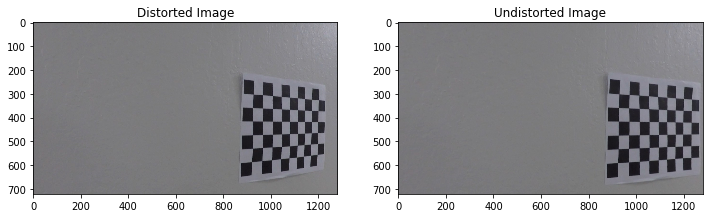

In [15]:
cal_img_example =utils.load_image(cal_img_paths[6])
cal_img_example_undistort = undistort_img(cal_img_example, mtx, dist)
fig, ax = plt.subplots(1, 2, figsize=(12, 14))
ax[0].imshow(cal_img_example)
ax[0].set_title('Distorted Image')
ax[1].imshow(cal_img_example_undistort)
ax[1].set_title('Undistorted Image')
plt.show()

This does works reasonably well, but not perfectly on all calibration images.

### Undistorting all test images


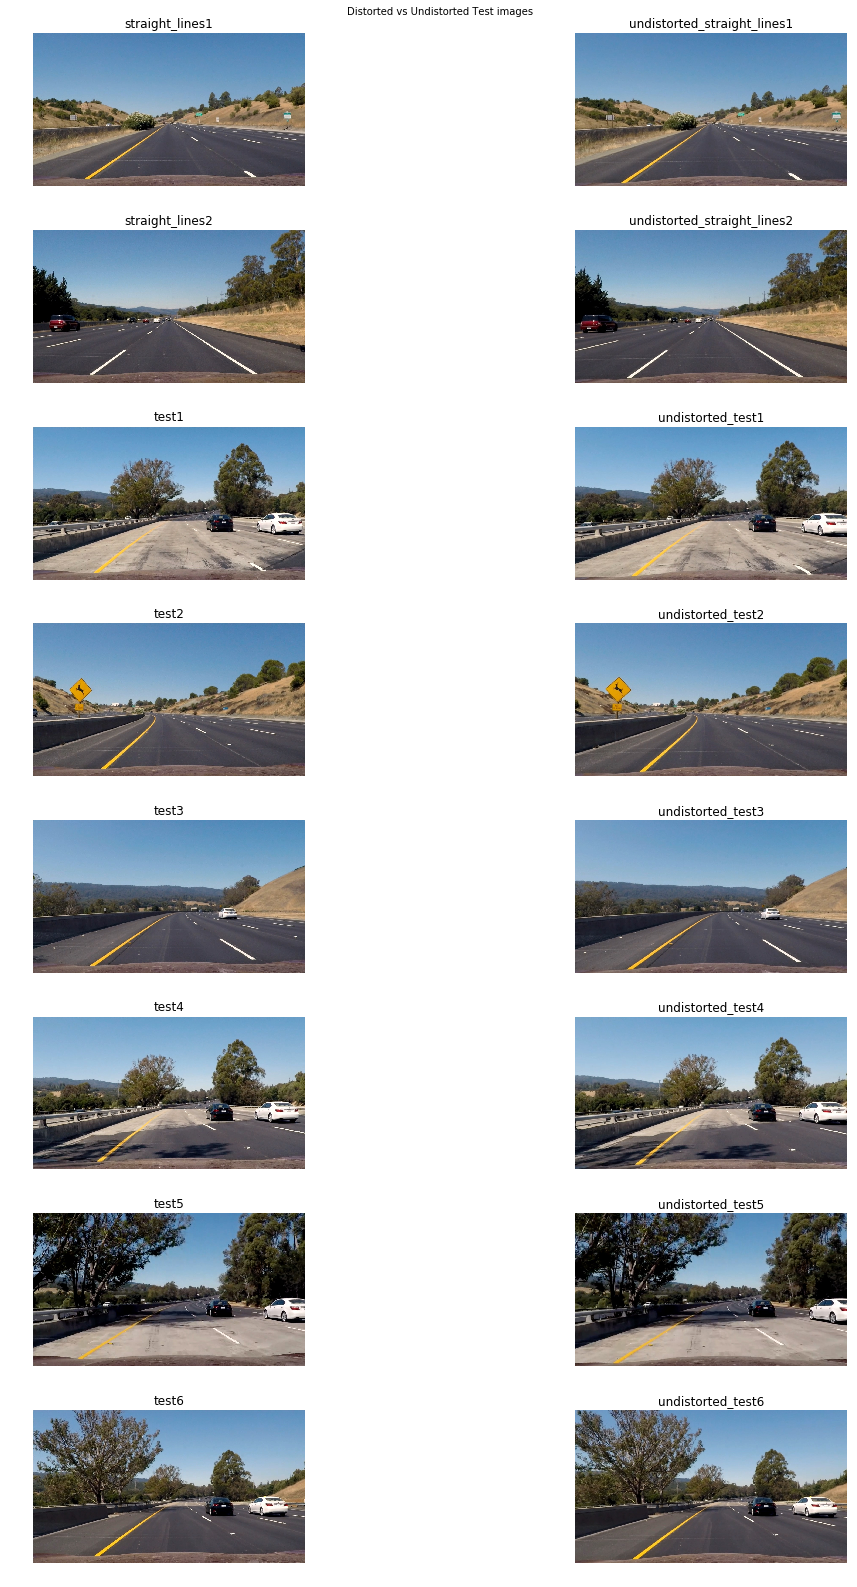

In [16]:
undist_test_imgs = [undistort_img(test_img, mtx, dist) for test_img in test_imgs]
undist_test_img_names = ['undistorted_' + test_img_name for test_img_name in test_img_names]
utils.show_img_lists([test_imgs, undist_test_imgs], [test_img_names, undist_test_img_names], 
                     title="Distorted vs Undistorted Test images", figsize=(18, 22))

As we can see, in the undistorted mode, the traffic signs and cars can be seen more from the front.

# Thresholding
In order to find pixels that are likely to be part of a line, we apply  color thresholding as well as gradient thresholding in this section. This will make it easier to later find a polynomial that fits the lane lines well. 

## Color Thresholds
First of all, we set color thresholds. This can be done, for example, in RGB or HSL space. First of all we define a color thresholding function that applies thresholds to an image's color channel.

In [17]:
def color_threshold(image, channel, low=0, high=255):
    """Applies color thresholding to an image."""
    # image is in grayscale
    if(image.shape[-1] < 3 or len(image.shape) < 3):
        img_channel=image
    img_channel = image[:,:,channel]
    binary = np.zeros_like(img_channel)
    binary[(img_channel > low) & (img_channel <= high)] = 1
    return binary
    

Next, we want to see which compare which of the RGB channels are best suited for detecting lane lines. We take one test image and compare grayscale - R - G - B - Hue - Saturation - Lightness.

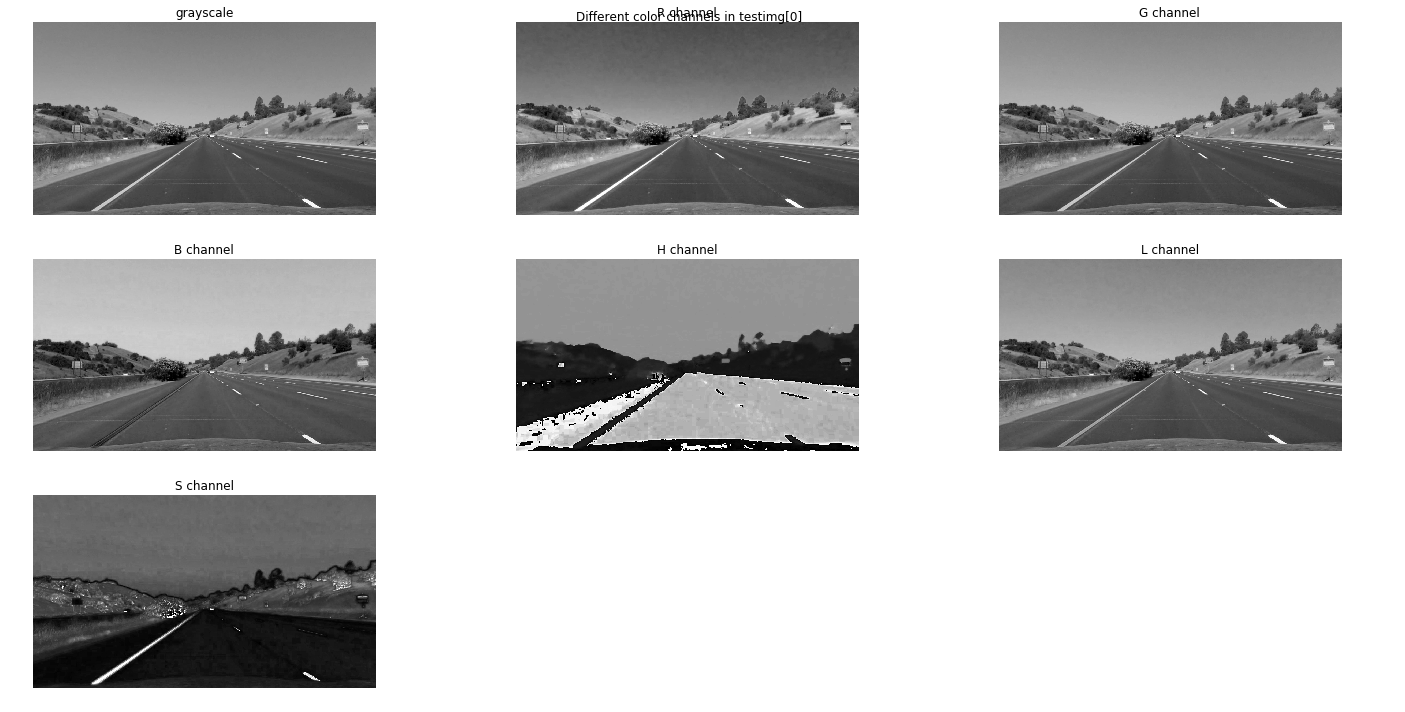

In [18]:
rgb_img = undist_test_imgs[0]
gray_img = utils.grayscale(rgb_img)
hls_img = utils.hls(rgb_img)

gray_channel = gray_img
r_channel = rgb_img[:, :, 0]
g_channel = rgb_img[:, :, 1]
b_channel = rgb_img[:, :, 2]
h_channel = hls_img[:, :, 0]
l_channel = hls_img[:, :, 1]
s_channel = hls_img[:, :, 2]

channel_imgs = [gray_channel, r_channel, g_channel, b_channel, h_channel, l_channel, s_channel]
channel_names = ['grayscale', 'R channel', 'G channel', 'B channel', 'H channel', 'L channel', 'S channel']

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 10))
for idx, ax in enumerate(axes.flat):
    if (idx < len(channel_names)):
        ax.imshow(channel_imgs[idx], cmap='gray')
        ax.set_title(channel_names[idx])
    ax.axis("off")

plt.suptitle('Different color channels in testimg[0]')
plt.tight_layout()
plt.show()
                         


We can see that the lines are best distinguishable in the R channel and especially in the HSL image's saturation channel. We can thus set a threshold on the S channel. As in the lectures, we set thresh = (90, 255)


In [19]:
hls_imgs = [utils.hls(img) for img in undist_test_imgs]
color_thresh_imgs = [color_threshold(img, channel=2, low=90, high=255) for img in hls_imgs]
color_thresh_imgs_names = test_img_names

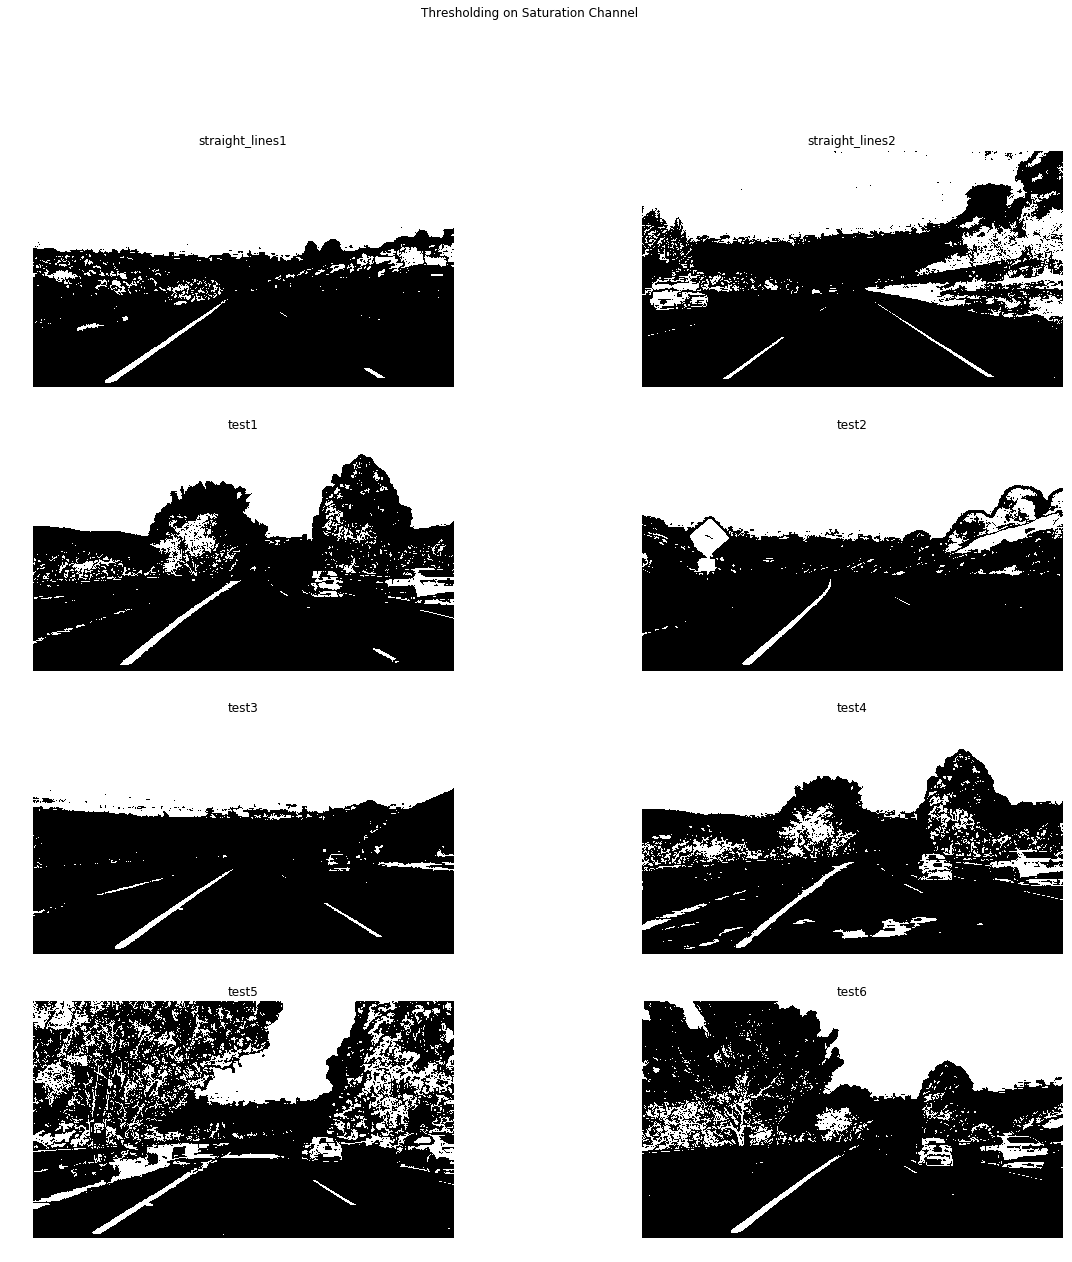

In [20]:
ncols=2
nrows = len(test_img_names) //2

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20))
for idx, ax in enumerate(axes.flat):
    ax.imshow(color_thresh_imgs[idx], cmap='gray')
    ax.set_title(color_thresh_imgs_names[idx])
    ax.axis("off")
plt.suptitle('Thresholding on Saturation Channel')
# plt.tight_layout()
plt.show()

As we can see, the color thresholding works and the lane lines are clearly visible.

## Gradient Thresholds
In the last exercise we used Canny edge detection to find possible lane lines in the image. Canny finds all possible lines in an image. Looking at lane lines, however, we have a smarter way for filtering pixels, because we know that the relevant lines are close to vertical. 

In the lectures, we saw that the sobel_x operator calculates the gradient in x-direction. Therefore, it emphasizes lines that are closer to the vertical and discards lines that are close to horizontal. This is what we need for finding lane lines.

### Sobel Operator

The Sobel operator needs pictures in grayscale. It has a kernel parameter, which determines how smooth the gradients are going to be. The kernel size can be any odd number. After converting the image with the Sobel operator, we define thresholds `thresh_min` and `thresh_max` that decide whether a detected line is kept or discarded. The Sobel operator lets us create a binary threshold to select pixels based on gradient strength: Pixels with strong gradient are kept, and strong gradients signify strong lines.

In the lecture, a threshold of `(30, 100)` was proven successful. In addition to the threshold parameters, Sobel operator needs us to specify a kernel size. The kernel size can be any odd number greater than or equal to 3. A larger kernel implies taking the gradient over a larger region of the image, or, in other words, a smoother gradient.



### Absolute Sobel Threshold

In [21]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255, ksize=5):
    
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if(orient=='x'):
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize)
    elif(orient=='y'):
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sobel_mask = np.zeros_like(scaled_sobel)
    sobel_mask[(scaled_sobel >= thresh_min) & (scaled_sobel < thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    return sobel_mask

Now we have to find good values for `thresh_min` and `thresh_max` as well as a kernel size that works well. 

### Comparing kernel sizes: x-direction
Before we define good gradient thresholds, we want to compare different kernel sizes. Let's compare `k=5`, `k=7`, `k=9`, `k=11` and `k=15`. We apply the sobel threshold on a test image. First, we look at the Sobel operator in x-direction.

In [22]:
sobel_test_img = test_imgs[0]

In [23]:
sobel5 = abs_sobel_thresh(sobel_test_img, orient='x', thresh_min=30, thresh_max=100, ksize=5)
sobel5_name = test_img_names[0]+ ' 5x5 kernel, x-direction'
sobel7 = abs_sobel_thresh(sobel_test_img, orient='x', thresh_min=30, thresh_max=100, ksize=7)
sobel7_name = test_img_names[0]+ ' 7x7 kernel, x-direction'
sobel9 = abs_sobel_thresh(sobel_test_img, orient='x', thresh_min=30, thresh_max=100, ksize=9)
sobel9_name = test_img_names[0]+ ' 9x9 kernel, x-direction'
sobel11= abs_sobel_thresh(sobel_test_img, orient='x', thresh_min=30, thresh_max=100, ksize=11)
sobel11_name = test_img_names[0]+ ' 11x11 kernel, x-direction'
sobel15 = abs_sobel_thresh(sobel_test_img, orient='x', thresh_min=30, thresh_max=100, ksize=15)
sobel15_name = test_img_names[0]+ ' 15x15 kernel, x-direction'

sobel_imgs = [sobel5, sobel7, sobel9, sobel11, sobel15]
sobel_names = [sobel5_name, sobel7_name, sobel9_name, sobel11_name, sobel15_name]

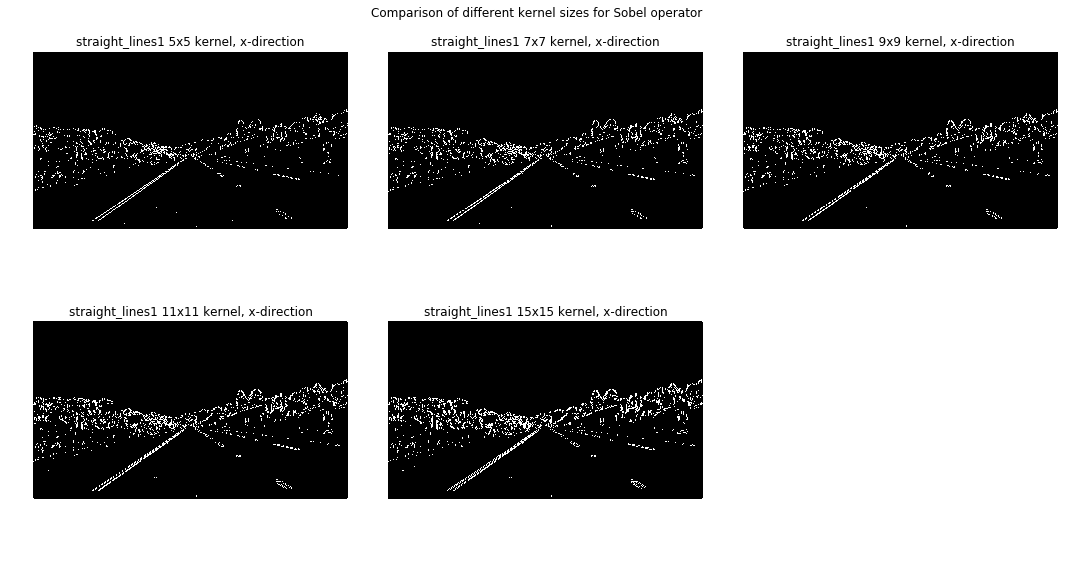

In [24]:
ncols = 3
nrows = len(sobel_imgs) // ncols + 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 8))
for idx, ax in enumerate(axes.flat):
    if(idx < len(sobel_imgs)):
        ax.imshow(sobel_imgs[idx], cmap='gray')
        ax.set_title(sobel_names[idx])
    ax.axis("off")
plt.suptitle('Comparison of different kernel sizes for Sobel operator')
plt.tight_layout()
plt.show()

We see that a kernel size of 15 works best. The difference between the kernel sizes, however, is relatively small.

## Combining Color and Gradient Thresholds

In [25]:
def color_gradient_threshold_with_plot(img_undist):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img_undist, cv2.COLOR_RGB2HLS)
    color_mask = color_threshold(hls, channel=2, low=90, high=255)
    
    sobel_thresh_min = 30
    sobel_thresh_max = 100
    
    sobel_x_mask = abs_sobel_thresh(img_undist, orient='x', 
                                    thresh_min=sobel_thresh_min, thresh_max=sobel_thresh_max, ksize=15)
    sobel_y_mask = abs_sobel_thresh(img_undist, orient='y', 
                                    thresh_min=sobel_thresh_min, thresh_max=sobel_thresh_max, ksize=15)


    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack((np.zeros_like(sobel_x_mask), sobel_x_mask, color_mask)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sobel_x_mask)
    combined_binary[(color_mask == 1) | (sobel_x_mask == 1) | (sobel_y_mask == 1)] = 1
    
    return combined_binary, color_binary

In [26]:
def color_gradient_threshold(img_undist):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    # if necessary also gradient direction or 
    hls = cv2.cvtColor(img_undist, cv2.COLOR_RGB2HLS)
    color_mask = color_threshold(hls, channel=2, low=90, high=255)
    
    sobel_thresh_min = 30
    sobel_thresh_max = 100
    
    sobel_x_mask = abs_sobel_thresh(img_undist, orient='x', 
                                    thresh_min=sobel_thresh_min, thresh_max=sobel_thresh_max, ksize=15)
    sobel_y_mask = abs_sobel_thresh(img_undist, orient='y', 
                                    thresh_min=sobel_thresh_min, thresh_max=sobel_thresh_max, ksize=15)

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sobel_x_mask)
    combined_binary[(color_mask == 1) | (sobel_x_mask == 1) | (sobel_y_mask == 1)] = 1
    
    return combined_binary

Now let's test the combined thresholds on a test image. 

In [27]:
undist_test_imgs[0].shape

(720, 1280, 3)

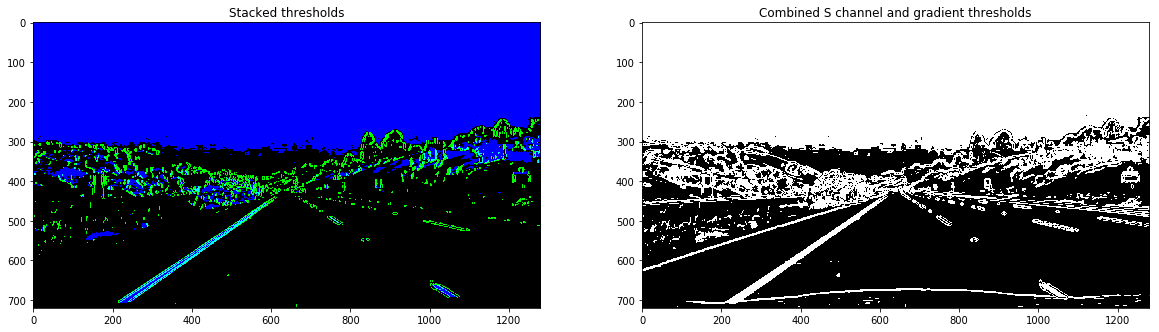

In [28]:

combined_binary, color_binary = color_gradient_threshold_with_plot(undist_test_imgs[0])
# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')

In [29]:
binary_imgs = [color_gradient_threshold(img) for img in undist_test_imgs]
binary_imgs_names = [name + ' binary' for name in test_img_names]

The result looks quite good! Now we can go to the next step: Perspective Transform.

## Perspective Transform
We now want to transform the image perspective to a bird's eye view. To do this, we need to define a trapezoid shape in our source image that will be transformed into a rectangle in the destination image. Like in the lecture, the trapezoid and rectangle are defined manually. Then, we will use opencv's `get_perspective_transform()` function.

In the following image, we can see the lane markings particularly well.

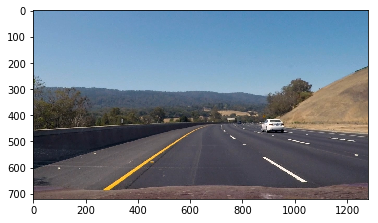

In [30]:
plt.imshow(test_imgs[4])

We now try and fit a trapezoid into this image.

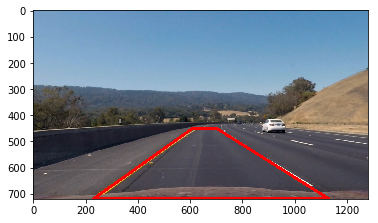

In [31]:
# copy test image since we're going to draw on it.
test_p_trafo = np.copy(undist_test_imgs[4])
(bottom_px, right_px) = (test_p_trafo.shape[0] - 1, test_p_trafo.shape[1] - 1) 
pts = np.array([[230,bottom_px],[610,450],[700,450], [1130, bottom_px]], np.int32)
cv2.polylines(test_p_trafo,[pts],True,(255,0,0), 10)
plt.imshow(test_p_trafo)

We have found the four points that define our trapezoid. For the destination points we choose two points that lie on the top and bottom line of the image and that are 

In [32]:
def get_perspective_transform(img):
    # the four trapezoid points defined above
    src = np.array([[210,bottom_px],[600,450],[700,450], [1110, bottom_px]], np.float32)
    offset=200
    img_size = (img.shape[1], img.shape[0])

    dst = np.array([[200, bottom_px], [200, 0], [1000, 0], [1000, bottom_px]], np.float32)
    dst_pts = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                [img_size[0]-offset, img_size[1]-offset], 
                                [offset, img_size[1]-offset]])
    # we need M as well as Minv to later re/transform the image for plotting
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, img_size)
    return warped, M, Minv

Let's now try these transforms out, first on the test images and then on the binary images from above. We plot the original image next to the warped image

In [33]:
test_imgs_warped = [get_perspective_transform(img)[0] for img in undist_test_imgs]
test_imgs_warped_names = [name + ' warped' for name in test_img_names]


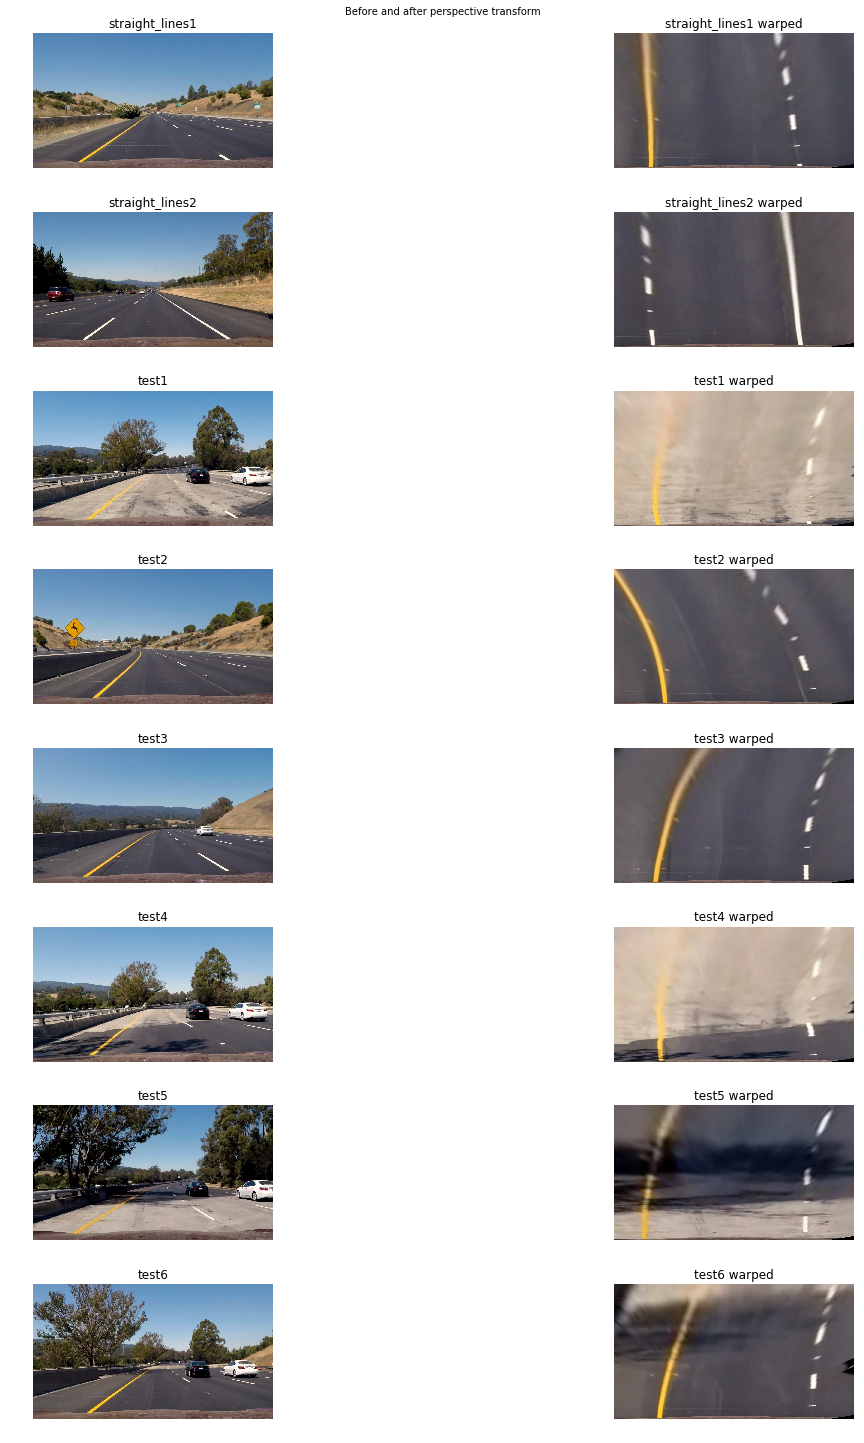

In [34]:
utils.show_img_lists(image_lists=[test_imgs, test_imgs_warped], image_names=[test_img_names, test_imgs_warped_names],
                    title='Before and after perspective transform')

The result looks good. Now we test the function also on our binary images:


In [35]:
binary_imgs_warped = [get_perspective_transform(img)[0] for img in binary_imgs]
binary_imgs_warped_names = [name + ' binary warped' for name in test_img_names]

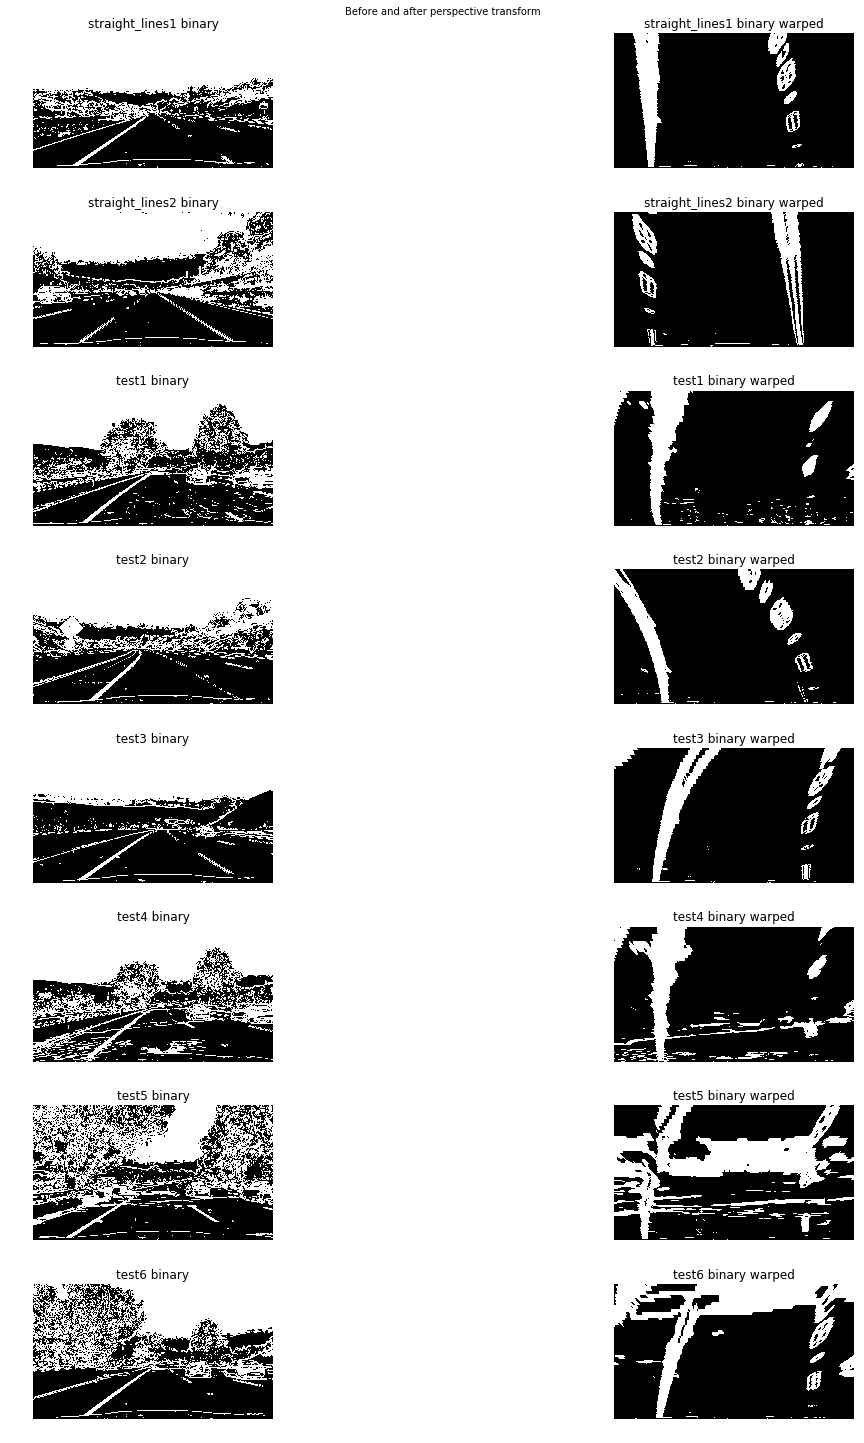

In [36]:
utils.show_img_lists(image_lists=[binary_imgs, binary_imgs_warped], 
                     image_names=[binary_imgs_names, binary_imgs_warped_names],
                    title='Before and after perspective transform')

# Preprocessing Pipeline
Now the image preprocessing is done. We write a pipeline:

In [37]:
# mtx and dist have been calculated above
def preprocess_image(img):
    """Applies all image preprocessing steps before lane detection."""
    # undistort image with the previously calculated `mtx` and `dst`
    undist_img = undistort_img(img, mtx=mtx, dist=dist)
    # apply color and gradient thresholding to get a binary image
    binary_img = color_gradient_threshold(undist_img)
    # apply perspective transform to get a warped image
    binary_warped_img, M, Minv = get_perspective_transform(binary_img)
    
    return warped_img, M, Minv

## Finding the Lane Pixels: Histogram Peaks

The initial lane line pixels are determined via the sliding window approach. Once that is done, we can have it easier by searching from prior. Therefore, however, our lines need some kind of memory:

In [38]:
class Line():
    """Class keeping track of a lane and all the lanes in the previous frame"""
    def __init__(self):
        # was the line detected in the last iteration? If yes, we can search from prior
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  

In [39]:
def search_lane_from_scratch(binary_warped):
    """Searches lane from binary warped image using histogram and sliding window technique"""
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & \
        (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        #If found > minpix pixels, recenter next window
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # fits polynomial to the detected lane line pixels
    left_fitx, right_fitx, ploty = fit_polynomial(binary_warped.shape, leftx, lefty, rightx, righty)
    
    return left_fitx, right_fitx, out_img


def fit_polynomial(img_shape, leftx, lefty, rightx, righty):
    """Fits polynomials to lane line pixels"""

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    try:
        left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
        right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    return left_fitx, right_fitx, ploty

    
def search_lane_from_prior(binary_warped, left_fit, right_fit):
    """Search lanes by only searching a region around a previous polynomial fit"""
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # get activated pixels in region around the previous polynomial
    left_lane_inds = ((nonzerox < (left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy +
                    left_fit[2] + margin)) & (nonzerox > (left_fit[0]*nonzeroy**2 +
                    left_fit[1]*nonzeroy + left_fit[2] - margin)))
    right_lane_inds = ((nonzerox < (right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy +
                    right_fit[2] + margin)) & (nonzerox > (right_fit[0]*nonzeroy**2 +
                    right_fit[1]*nonzeroy + right_fit[2] - margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly_from_prior(binary_warped.shape, leftx, lefty, rightx, righty)

    return left_fitx, right_fitx, ploty

In [40]:
# this function is not completely right yet. We need to figure out how to use ym_per_pix and xm_per_pix
def get_curvature_real(fitx, ploty):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # fit new polynomial to x, y in the real world space
    fit_cr = np.polyfit(y * ym_per_pix, fitx * xm_per_pix, 2)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    y_eval_meters = ym_per_pix * y_eval

    A_l = fit_cr[0]
    B_l = fit_cr[1]
    C_l = fit_cr[2]
    
    # Radius of curvature in meters
    curverad =  ((1 + (2 * A_l * y_eval_meters + B_l)**2)**1.5) / (abs(2 * A_l))

    return curverad

In [56]:
class LaneFinder():
    """Class for lane finding. """
    def __init__(self):
        # Lines are only once initialized per list of images -> .detected values remain
        left_lane = Line()
        right_lane = Line()
        
    def get_result(self, image, warped, left_fitx, right_fitx, ploty, Minv, curvature):
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
        
        # Ab hier nochmal neu        
        # Put text on an image
        font = cv2.FONT_HERSHEY_SIMPLEX
        text = "Radius of Curvature: {} m".format(int(curvature))
        cv2.putText(result,text,(400,100), font, 1,(255,255,255),2)
        # Find the position of the car
        pts = np.argwhere(newwarp[:,:,1])
        position = LaneFinder.get_position(pts)
        if position < 0:
            text = "Vehicle is {:.2f} m left of center".format(-position)
        else:
            text = "Vehicle is {:.2f} m right of center".format(position)
            
        cv2.putText(result,text,(400,150), font, 1,(255,255,255),2)
        
        return result

        
    
    def find_lanes(self, image):
        """Finds lanes and lane curvatures in a single images and plots them."""
        binary_warped, M, Minv = preprocess_image(image)
        
        # find lane pixels
        if(self.left_lane.detected and self.right_lane.detected):
            ###TODO: ergänze Paremeter best fit or WHAT?
            left_fitx, right_fitx, ploty, out_img = search_lane_from_prior(binary_warped, 
                                                                           self.left_lane.best_fit, self.right_lane.best_fit)
        else:
            left_fitx, right_fitx, ploty, out_img = search_lane_from_scratch(binary_warped)
            
        # find curvatures 
        left_curve_radius = get_curvature_real(left_fitx, ploty)
        right_curve_radius = get_curvature_real(right_fitx, ploty)
        
        # Does sanity check really need to output something or is it enought that the class variables are set
        left_fitx, right_fitx = self.sanity_check()
        
        # left_curve_radius is enough since both curve radii should be about the same
        return self.get_result(image, binary_warped, left_fitx, right_fitx, ploty, Minv, left_curve_radius)
    
    def get_car_position(self, pts, image_shape = (720, 1280)):
        """Calculates car position from the center of the lane. Returns car's distance from the center of the road in 
        meter"""

        position = image_shape[1]/2
        left  = np.min(pts[(pts[:,1] < position) & (pts[:,0] > 700)][:,1])
        right = np.max(pts[(pts[:,1] > position) & (pts[:,0] > 700)][:,1])
        center = (left + right) / 2

        # Define conversions in x and y from pixels space to meters,
        # assume the lane is about 30 meters long and 3.7 meters wide
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        dist_in_m = (position - center)*xm_per_pix
        return dist_in_m
    
    def sanity_check(self, lane, curverad, fitx, fit):
        # Sanity check for the lane
        lane.current_fit = fit

        if abs(curverad - 2000) / 2000 < 2:
            lane.detected = True

            #Keep a running average over 3 frames
            if len(lane.recent_xfitted) > 5 and lane.recent_xfitted:
                lane.recent_xfitted.pop()
                lane.recent_fits.pop()

            lane.recent_xfitted.append(fitx.reshape(1,-1))
            lane.recent_fits.append(fit.reshape(1,-1))

            if len(lane.recent_xfitted) > 1:
                lane.bestx = np.mean(np.vstack(lane.recent_xfitted),axis=1)
                lane.best_fit = np.mean(np.vstack(lane.recent_fits),axis=1)

            lane.bestx = fitx
            lane.best_fit = fit

            return lane.bestx

        else:
            lane.detected=False

        return  lane.bestx if lane.bestx is not None else lane.current_fit 
        

In [57]:
lf = LaneFinder()

In [58]:
type(lf)

__main__.LaneFinder

## Erster Test am Video


In [59]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

LF = LaneFinder()
print(type(LF))
white_output = 'project_video_output'
video_output_white = VideoFileClip("project_video.mp4")
video_white = clip1.fl_image(LF.find_lanes)
video_white.write_videofile(video_output_white, audio=False)


<class '__main__.LaneFinder'>


OSError: [WinError 6] Das Handle ist ungültig

In [48]:
os.listdir()

['.DS_Store',
 '.git',
 '.gitignore',
 '.ipynb_checkpoints',
 'advanced_lane_finding.py',
 'calibration_coefficients',
 'camera_cal',
 'challenge_video.mp4',
 'examples',
 'example_writeup.pdf',
 'harder_challenge_video.mp4',
 'LICENSE',
 'output_images',
 'project_video.mp4',
 'README.md',
 'set_git.sh',
 'solution.ipynb',
 'test_images',
 'utils.py',
 'writeup_template.md',
 '__pycache__']